# Feature Extraction, Feature Generation, Dimensionsreduzierung und PCA

> __In God we trust, all others bring data__

>William Edwards Deming (1900-1993)


In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')


<IPython.core.display.Javascript object>

<h2 id="tocheading">Table of Contents</h2>
<div id="toc"></div>

## Einleitung

### Format der „Folien“

Hierbei handelt es sich um ein sogenanntes Jupyter Notebook.

<https://jupyter.org>

Eine Mischung aus Code, Bildern und Text mit Teilweise interaktiven Elementen.

Auch lokal auf euren Rechnern ausführbar. 

<img src="./ml/images/jupyter.png" alt="Jupyter Logo" style="width: 200px;"/>

### scikit-learn (sklearn)

Programmbeispiele und Plots in der Vorlesung sind mithilfe des `scikit-learn` Projektes erstellt.

<http://scikit-learn.org/stable>

`scikit-learn` ist eine Bibliothek für Python mit vielen Methoden und Algortihmen für Data Mining / Machine Learning

Ausführlicher User-Guide mit Beispielen und mathematischen Hintegründen:
<https://scikit-learn.org/stable/user_guide.html>

<img src="./ml/images/logo.png" alt="Scikit Logo" style="width: 200px;"/>

### pandas

Für die Daten-Vorverarbeitung werden wir hauptsächlich `pandas` verwenden.

Pandas stellt den `DataFrame` zur Verfügung, eine tabellenartige Datenstruktur mit vielen nützlichen Methoden

<https://pandas.pydata.org>


<img src="https://upload.wikimedia.org/wikipedia/commons/e/ed/Pandas_logo.svg" alt="pandas log" style="width: 300px;">

Alle benötigten Pakete sind in der `conda` Umgebung enthalten, zur Erinnerung:
 
Umgebung erstellen:
```
conda env create -n smd -f environment.yml
```


Umgebung aktualisieren:
```
conda env update -n smd -f environment.yml
```   


Ohne `conda`:
```
pip install [--user] scikit-learn pandas
```


> Pedregosa, Fabian, et al. "Scikit-learn: Machine learning in Python." the Journal of machine Learning research 12 (2011): 2825-2830.

### Notationen

*Für weiteres siehe "Elements of statistical Learning" von Trevor Hastie. https://web.stanford.edu/~hastie/ElemStatLearn/ (Kostenloses E-Book)* 

Ich versuche folgenden Namenskonventionen zu folgen.

* Großbuchstaben wie  $X$ oder $Y$ bezeichnen generische Aspekte einer Variable (i.e. die tatsächliche Zufallsvariable)
* Beobachtungen/Realisierungen werden klein geschrieben. Die i-te Realisierung in $X$ ist $x_i$
* Matrizen sind groß- und fettgedruckt $\boldsymbol{X}$
* Beobachtungen/Realisierungen sind *Zeilen* der Matrix während die beobachteten Größen in den *spalten* stehen.

Wenn man beispielsweise $d=2$ Variablen, das Alter und das Gewicht von $N = 100$ Menschen misst, dann erhält man eine $N \times d$ Matrix $\boldsymbol{X}$.

eine Beobachtung, bzw. Zeile, der Matrix wird geschrieben als $x_i = (\mathrm{Alter}, \mathrm{Gewicht} )$.

Alle Messungen der Größe *Gewicht* sind geschrieben als  $\boldsymbol{x}_{\bullet 1}$, analog zum `numpy` indexing `X[:, 1]`

In [2]:
%matplotlib inline
from ml import plots
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.colors import ListedColormap

discrete_cmap = ListedColormap([(0.8, 0.2, 0.3), (0.1, 0.8, 0.3), (0, 0.4, 0.8)])

plots.set_plot_style()

### Wiederholung

Beim letzten mal:

Lineare Fisher Diskriminanzanalyse:

> Finde die Hyperebenen welche zwei Populationen optimal nach Fisher Kriterium trennt.

Das kleine Beispiel unten zeigt wie eine Diskriminanzanalyse mit dem scikit-learn Paket durchgeführt werden kann.


In [3]:
from sklearn.datasets import make_blobs
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

X, y = make_blobs(n_samples=250, centers=2, random_state=12)
clf = LinearDiscriminantAnalysis()
lda = clf.fit(X, y)

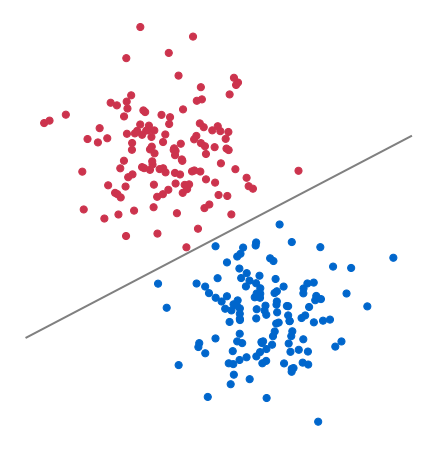

In [4]:
plt.axes(aspect=1)  # make sure x and y have same scale
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap=discrete_cmap)
plots.draw_linear_regression_function(lda, color='gray')
plt.axis('off')
None # to keep notebook output from cluttering

## Probleme bei hochdimensionalen Daten:

> __Curse of dimensionality (Fluch der Dimensionalität)__
>
> ist ein Begriff, der von Richard Bellman eingeführt wurde,   
> um den rapiden Anstieg im Volumen beim Hinzufügen weiterer Dimensionen in einen mathematischen Raum zu beschreiben.
>
>[https://de.wikipedia.org/wiki/Fluch_der_Dimensionalität](https://de.wikipedia.org/wiki/Fluch_der_Dimensionalit%C3%A4t)

Je höher die Dimension des Raumes, umso mehr Beobachtungen braucht man um den Raum *ausreichend* abzudecken.

Im folgenden Beispiel werden 100 Punkte aus eine uniformen Verteilung zwischen 0 und 1 gezogen.  
Darunter wird das Histogram gezeichnet.  
Zunächst in einer Dimension und dann in zwei.  

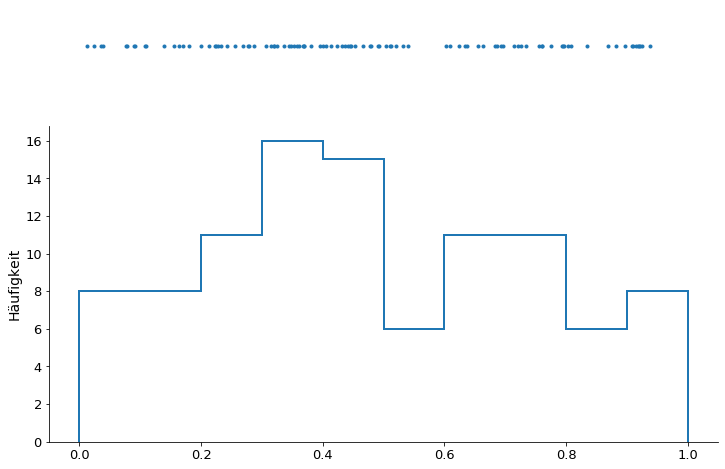

In [5]:
sample = np.random.uniform(low=0.0, high=1.0, size=100)

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [1, 4]})

ax1.plot(sample, np.zeros_like(sample), '.')
ax1.set_axis_off()

ax2.hist(sample, bins=np.arange(0, 1.1, 0.1),histtype='step', lw=2)
ax2.set_ylabel('Häufigkeit')
None

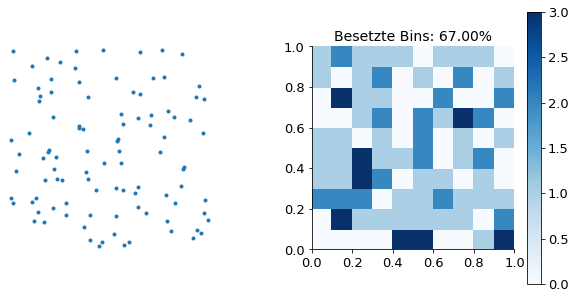

In [6]:
# Ein ausführliches plotting beispiel.
# In Zukunft sind viele Plotting-Funktionen versteckt und nicht in diesem Notebook.

#gleichverteilte Zahlen in zwei Dimensionen
sample = np.random.uniform(low=0.0, high=1.0, size=[100, 2])

#einzelne Punkte plotten
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(10, 5))
ax1.plot(sample[:, 0], sample[:, 1], '.')
ax1.axis('off')
ax1.set_aspect('equal')

# das histogram plotten
histogram_entries, _, _, im = ax2.hist2d(
    sample[:, 0],
    sample[:, 1],
    bins=np.arange(0, 1.1, 0.1),
    cmap='Blues',
    vmin=0,
)

# anteil besetzter bins bestimmen
density = np.count_nonzero(histogram_entries) / histogram_entries.ravel().shape[0]

ax2.set_title('Besetzte Bins: {:.2%}'.format(density))
ax2.set_aspect('equal')

fig.colorbar(im, ax=ax2)
fig.colorbar(im, ax=ax1).ax.set_visible(False)
None

Im 1D Beispiel ist jeder Bin besetzt. Es gibt keine leeren bins. Im 2D Beispiel sind bereits ungefähr ein Drittel der Bins leer. 

Lösungsmöglichkeiten:

1. Mehr Daten Speichern und höhere Kosten in Kauf nehmen.
2. Größere Bins benutzen und die Verteilung weniger genau wiedergeben.
3. Dimensionen reduzieren und eventuell Informationen verwerfen. 

Mehr Daten zu speichern ist auch heutzutage nicht immer möglich.

### Beispiel IceCube
Der IceCube Neutrino Detektor am Südpol nimmt bis zu 1 TB Daten am Tag auf.   
Per Satelit können nur 100 GB pro Tag übetragen werden.  
Die restlichen Daten werden einmal pro Jahr per Schiff versandt.  

<img src="./ml/images/icecube.jpg" alt="Drawing" style="width: 400px;"/>

### Beispiel SKA
Das Square Kilometer Array ist ein geplantes Radio Teleskop welches in Südafrika und Australien gebaut werden soll.

Es wird aus mehreren zehntausenden Antennen bestehen.

Die erwartete Datenrate liegt in der Größenordnung von mehreren  __Petabyte pro Sekunde__.

Eine Speicherung ist mit heutiger Technologie völlig unmöglich.



In [7]:
from IPython.display import IFrame

IFrame('https://www.youtube.com/embed/8BBoDw2qVD0?rel=0', width=800, height=600)

Hochdimensionale Daten führen aber auch zu ganz Grundsätzlichen, mathematischen,  Problemen.
Interessante Diskussion hier: 
> Why is Euclidean distance not a good metric in high dimensions?
>https://stats.stackexchange.com/questions/99171/why-is-euclidean-distance-not-a-good-metric-in-high-dimensions

Benötigt wird also irgendeine Art von Dimensionsreduktion.

## Datenreduktion

Zwei grundsätzliche Ansätze:

1. Feature Extraction
  * Erzeugen neuer Attribute, die Informationen mehrerer Attribute zusammenfassen
  * Automatisches Reduzieren der Dimension durch minimieren der Varianz (Hauptkomponenteanalyse)
   
1. Feature Selection
  * Verwerfen von redundanten und schwachen Attributen

### Feature Extraction

#### Beispiel 1: Einfache Datentransformation

Gegeben seien Datenpunkte $X = (x_1, x_2, ...) , Y = (y_1, y_2, ...) $.

Angenommen durch Fachwissen, bekannte physikalische Zusammenhänge oder einfach genaues hinsehen sei bekannt, 
dass die Daten sich besser durch Polarkoordinaten ausdrücken lassen.

$$
 \begin{align}
     r &= x^2 + y^2 \\
     \phi &= \operatorname{arctan2}(y, x)    
 \end{align}
$$

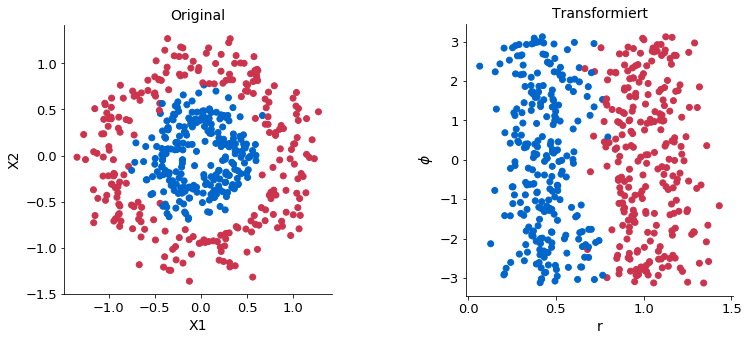

In [8]:
from sklearn.datasets import make_circles

def transform(X1, X2):
    r = np.sqrt(X1**2 + X2**2)
    phi = np.arctan2(X2, X1)
    return r, phi

X, y = make_circles(n_samples=500, noise=0.15, factor=0.4, )
r, phi = transform(X[:, 0], X[:, 1])

#erstelle eine figure mit zwei subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plt.subplots_adjust(wspace=0.5)

#plotte die ursprünglichen Punkte
ax1.scatter(X[:, 0], X[:, 1], c=y, cmap=discrete_cmap)
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')
ax1.set_title('Original')
ax1.set_aspect(1)

#plotte die transformierten Punkte
ax2.scatter(r, phi, c=y, cmap=discrete_cmap)
ax2.set_xlabel('r')
ax2.set_ylabel('$\phi$')
ax2.set_title('Transformiert')
None

In diesem Beispiel is es ausreichend, allein das Attribut $r$ zu speichern um die Daten in zwei Klassen zu 
unterteilen.

Die Dimensionalität reduziert sich also um die Hälfte.


#### Beispiel 2: Datenrepresäntation

Häufig sind die Daten nicht in der richtigen Darstellung für die statistischen Methoden die wir anwenden wollen.
In diesem Beispiel sollen Textschnippsel aus dem Internet in verschiednen Kategorien eingeteilt werden.
Dazu müssen aus den Rohdaten, den einzelnen Texten, irgendwie Variablen abgeleitet werden, die uns einen Hinweis auf die Kategorie geben können.

Wir laden zunächst einen Beispieldatensatz mit Texten aus zwei Kategorien.

In [9]:
from sklearn.datasets import fetch_20newsgroups
from collections import Counter

print('Heide: ')
atheist_texts = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'), categories=['alt.atheism'])
print(atheist_texts.data[3])

print('---'*10)
print('---'*10)

print('Glaubender: ')
religous_texts = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'), categories=['talk.religion.misc'])
print(religous_texts.data[0])

Heide: 




Yup.  I can hear the _millions_ cheering for DK right now!  Josef Stalin eat
your heart out!  :)
--
Bake Timmons, III
------------------------------
------------------------------
Glaubender: 


Paradise and salvation are not the same thing.  Salvation is better.  Refer
to John 14:2.


__Hypothese 1__: Atheisten benutzen mehr Wörter

Wir füllen die Längen der Texte in normierte Histogramme ein um zu sehen, ob sich die Verteilungen unterscheiden.

(1156.54375, 1318.0053050397878)

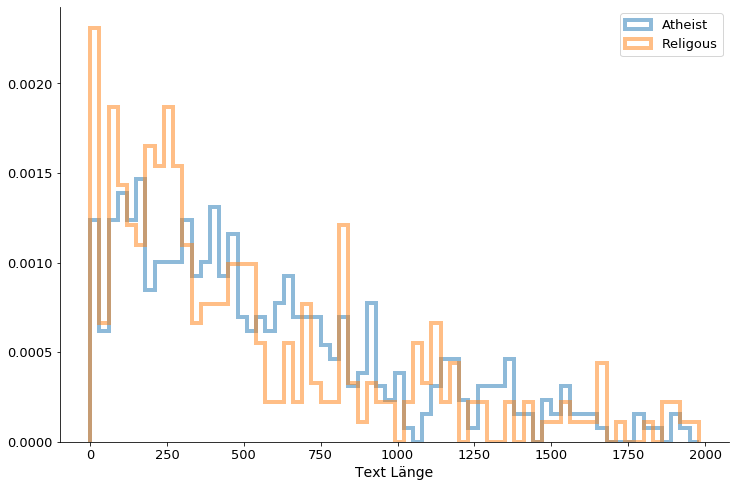

In [10]:
atheist_lengths = list(map(len, atheist_texts.data))
religous_lengths = list(map(len, religous_texts.data))

# Histogrammieren det Textlängen. 
bins =  np.arange(0, 2000, 30)
plt.hist(atheist_lengths, bins=bins, alpha=0.5, density=True, histtype='step', lw=4, label='Atheist')
plt.hist(religous_lengths, bins=bins, alpha=0.5, density=True, histtype='step', lw=4, label='Religous')
plt.xlabel('Text Länge')
plt.legend()
None

np.mean(atheist_lengths), np.mean(religous_lengths)

Keine signifikanten Unterschiede per Auge zu sehen.

__Hypothese 2__: Atheisten benutzen längere Wörter

Selbes vorgehen wie oben

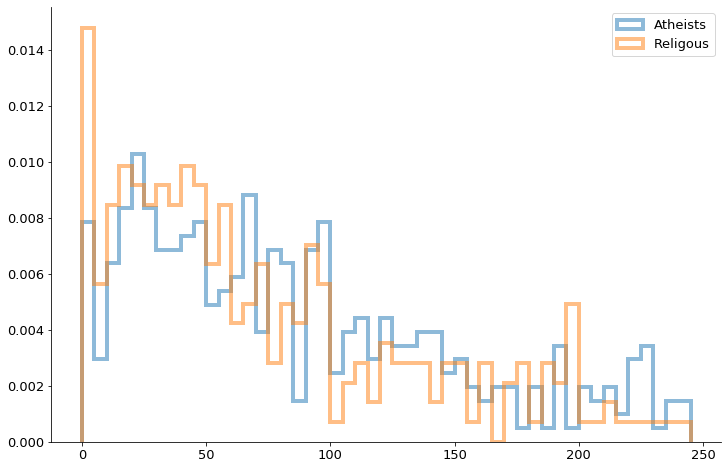

In [11]:
atheist_lengths = list(map(lambda s: len(s.split()), atheist_texts.data))
religous_lengths = list(map(lambda s: len(s.split()), religous_texts.data))


# Histogrammieren det Wortlängen. 
bins =  np.arange(0, 250, 5)
plt.hist(atheist_lengths, bins=bins, alpha=0.5, density=True, histtype='step', lw=4, label='Atheists')
plt.hist(religous_lengths, bins=bins, alpha=0.5, density=True, histtype='step', lw=4, label='Religous')
plt.legend()
None


Wo kommen die großen Wortlängen her? Stichwort __Datenbereinigung__. Manche der Texte Enthalten Signaturen oder andere Zeichenfolgen die nicht zum Haupttext gehören.


In [12]:
atheist_texts.data[2].split()[40:]

["It's",
 'not',
 'a',
 'very',
 'good',
 'example',
 'to',
 'show',
 'citizenship',
 'without',
 'descent.',
 'Karl',
 '-----------------------------------------------------------------------------']

__Hypothese 3__: Atheisten benutzen andere Wörter.

65 225 72 137 107 81 147 83 95 94 93 62 63
68 104 75 44 45 46 47 178 56 58 91


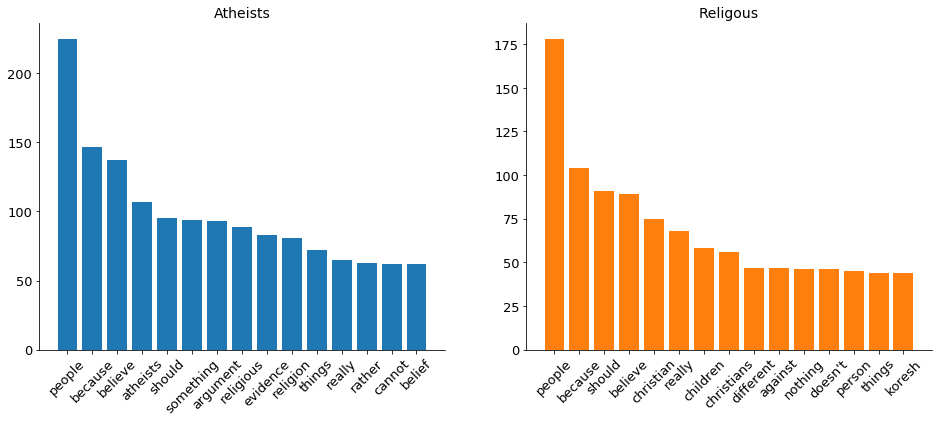

In [13]:
import string


def extract_words(texts):
    return (
        ' '.join(texts.data)           # join all texts to one giant string
        .lower()                       # all to lower case
        .translate(string.punctuation) # remove punctuation ,.- etc.
        .split()                       # split sring into list of words at whitespace
    )


def most_common(words, n, min_length=5):
    counter = Counter(filter(lambda w: len(w) > min_length, words))
    return dict(counter.most_common(n))


atheist_words = extract_words(atheist_texts)
common_atheist_words = most_common(atheist_words, 15)

religous_words = extract_words(religous_texts)
common_religous_words = most_common(religous_words, 15)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title('Atheists')
ax1.bar(common_atheist_words.keys(), common_atheist_words.values())

ax2.set_title('Religous')
ax2.bar(common_religous_words.keys(), common_religous_words.values(), color='C1')


for ax in (ax1, ax2):
    for tick in ax.get_xticklabels():
            tick.set_rotation(45)


atheist_set = set(common_atheist_words.values())       
religous_set = set(common_religous_words.values())
s = atheist_set | religous_set
print(*(atheist_set - religous_set))
print(*(religous_set - atheist_set))

Die benutzten Wörter unterscheiden sich also deutlich. Die Anzahl der Wörter die man benutzen kann um die Kategorie über die Wortfrequenz zuzuordnen ist in diesem Beispiel relativ klein. 


In echten Problemen ist das natürlich wesentlich aufwendiger und man benötigt andere Techniken und mehr Beispiele.


Diese Art der Feature Extraction erfordert irgendeine Art von Expertenwissen und wird bei steigender Dimensionalität komplizierter bis unmöglich. 

Expertenwissen bedeuted häufig, dass bekannte physikalische Zusammenhänge ausgenutzt werden. Manchmal sind es aber gerade diese physikalischen Zusammenhänge die unbekannt sind und gelernt werden sollen. 

### PCA (Hauptkomponentenanalyse)

Die Hauptkomponentenanalyse sucht nach einer Basis im Raum indem die Varianz entlang der Basisvektoren maximiert wird.

Gegeben seien also $N$ Datenpunkte mit $d$ Dimensionen die auf $k < d$ Dimensionen transformiert werden sollen.

Dazu wird der Raum in eine neue Basis transformiert. Es werden also eventuell mehrere Dimensionen/Attribute zu einer neuen Zusammengefasst.  

Grober Ablauf der PCA

0. Zentriere die Daten auf ihren Mittelwert.
1. Berechne die Kovarianzmatrix aus der Datenmatrix $\mathbf{X}$
2. Berechne Eigenwerte und Eigenvektoren der Matrix
3. Wähle die $k$ größten Eigenwerte und zugehörigen Eigenvektoren aus. 
4. Bilde eine $d \times k$ Matrix $\mathbf{W}$ mit den $k$ Eigenvektoren als Spalten.
5. Wende $\mathbf{W}$ auf jede Zeile aus $x$ aus $\mathbf{X}$ an $x^\prime = \mathbf{W}^T \cdot x^T $ 
    

###### 1. Zentrierung 

Berechne die Mittelwertvektoren $\mu$:

$$
\mathbf{\mu} = \begin{pmatrix}
    \bar{\mathbf{x}}_1 \\
    \ldots \\
    \bar{\mathbf{x}}_d \\
\end{pmatrix}
 = \frac 1 N
 \begin{pmatrix}
    \sum_{i=0}^{N} \mathbf{x}_{1, i} \\
    \ldots \\
    \sum_{i=0}^{N} \mathbf{x}_{d, i} \\
\end{pmatrix}
$$

Anders ausgedrückt:
$$
\mathbf{\mu} = \begin{pmatrix}
    \text{Mittelwert aller Beobachtungen von Attribut 1}\\
    \ldots \\
    \text{Mittelwert aller Beobachtungen von Attribut d}\\
\end{pmatrix}
$$

Neuer Datenpunkt:

   $$
      x^{\prime}_i = x_i - \mathbf{\mu}
   $$

###### 2. Kovarianz

Die Kovarianz einer Zufallsvariable $X$ beliebiger Dimension.
$$
\operatorname {Cov} (X)=\operatorname {E} {\bigl [}(X-\operatorname {E} (X))\cdot (X-\operatorname {E} (X))^T{\bigr ]}
$$

Schätzung der Kovarianzmatrix auf Daten auch durch *einfache* Matrixoperation möglich. 

###### 3. Eigenwerte und Vektoren

Berechne die $d$ verschiedenen Eigenwerte der Kovarianzmatrix $ \operatorname {Cov} (\mathbf {X} )$.

Erhalte Eigenwerte $\lambda_1, \ldots, \lambda_d$ mit passenden Eigenvektoren $v_1, \ldots, v_d$


###### 4. Sortierung und Auswahl

Sortiere die Indizes der Eigenwerte und Vektoren so dass gilt 

$$
\lambda_1 > \lambda_2 > \lambda_3 \ldots > \lambda_d
$$

Wähle die $k$ größten Eigenwerte aus und verwerfe alle anderen Eigenwerte und Vektoren.



###### 5. Bildung der Matrix

Nutze die $k$ ausgewählten Eigenvektoren als Spalten in der Matrix $\mathbf{W}$

$$
\mathbf{W} = \begin{pmatrix}
    v_1, 
    \ldots,  
    v_k
\end{pmatrix}
= \begin{pmatrix}
    v_{1,1}, 
    \ldots,  
    v_{k, 1} \\
    \ldots \\
        v_{1,d}, 
    \ldots,  
    v_{k, d}
\end{pmatrix}
$$

###### 6. Transformierung 

Multipliziere die Transformationsmatrix $\mathbf{W}$ mit jeder Beobachtung $x_i$ in $\mathbf{X}$ um die auf $k$ Dimensionen beschränkten Punkte zu erhalten.

$$
\mathbf{X^\prime} = \mathbf{X} \mathbf{W}
$$

In [22]:
N = 8 # anzahl beobachtungen
d = 4 # anzahl variablen/ dimensionen

X = np.random.normal(size=(N, d)) # zufällige daten
X = X - X.mean(axis=0)

# print(X.shape)
c = np.cov(X, rowvar=False)

l, W = np.linalg.eigh(c)

# Reihenfolge umkehren. Größte Eigenwerte zuerst.
l = l[::-1]
W = W[:, ::-1]

X_prime = X @ W
from sklearn.decomposition import PCA
pca = PCA()
print('Per Hand: \n', np.round(X_prime, 2),'\n \n sklearn \n', np.round(pca.fit_transform(X), 2))

# testen aller einträge auf gleichheit (bis auf vorzeichen)
print('\n All close:', np.allclose(np.abs(X_prime), np.abs(pca.fit_transform(X))))

Per Hand: 
 [[-0.05 -0.17 -0.97 -0.  ]
 [-1.29  0.27  0.26 -0.65]
 [-1.56 -2.22 -0.58  0.11]
 [ 1.32 -1.2   0.12  0.04]
 [-0.34  1.62 -0.09  0.45]
 [ 3.07 -0.83  0.53 -0.02]
 [-1.92  0.15  1.11  0.21]
 [ 0.78  2.38 -0.4  -0.13]] 
 
 sklearn 
 [[-0.05 -0.17 -0.97  0.  ]
 [-1.29  0.27  0.26  0.65]
 [-1.56 -2.22 -0.58 -0.11]
 [ 1.32 -1.2   0.12 -0.04]
 [-0.34  1.62 -0.09 -0.45]
 [ 3.07 -0.83  0.53  0.02]
 [-1.92  0.15  1.11 -0.21]
 [ 0.78  2.38 -0.4   0.13]]

 All close: True



#### Beispiel in 3D

Künstlicher Datensatz mit $d = 3$ Dimensionen wird auf $k=2$ Dimensionen reduziert. 
Der Datensatz wird gezogen aus zwei Gaussverteilungen mit unterschiedlichen Mittelwerten und gleicher Kovarianzmatrix.
Die Darstellung unten Zeigt die Punktwolke aus vier Verschiedenen Richtungen.

In [ ]:
X, y = make_blobs(n_samples=500, n_features=3, random_state=2, cluster_std=3)
plots.plot_3d_views(X, y)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
transformed = pca.fit_transform(X)

plots.plot_3d_views(transformed, y)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
transformed = pca.fit_transform(X)
plt.scatter(transformed[:, 0], transformed[:, 1], c=y, cmap=discrete_cmap)
None

#### Beispiel Gesichtserkennung 

Man betrachte jeden einzelnen Pixel eines Bildes als Attribut dessen Wert der Grauwert des Pixels ist.

So wird ein Bild zu einem 1D Vektor. Mehrere Bilder ergeben wieder die Datenmatrix $\mathbf{X}$

Ein Bild mit $64 \times 64$ Pixeln wird so zu einem Vektor der Länge $4096$.

##### Ein einfacher Gesichtserkennungsalgorithmus

Angenommen die Aufgabe wäre die Zuordnung von Fotos aller Studenten der TU zu deren Namen.   
Gesucht wird also eine Funktion die aus einem Foto einen Namen macht. 

Idee:
1. Speichere Bilder von allen Studenten in einer Matrix $\mathbf{X}$ der Dimension $\text{Anzahl Studenten} \times \text{Anzahl Pixel}$ und einen Labelvektor $y$ der Länge $N$ der die Namen (oder Matrikelnummern) enthält.
2. Berechne die Distanz $D$ zwischen einem neuen Foto $x_{\text{neu}}$ zu allen in $\mathbf{X}$ gespeicherten Bildern. 
3. Gebe zurück das $y_i$ für das $i$ bei dem $D(x_{\text{neu}}, x_i)$ minimal ist.

Probleme: 
 - Alle Bilder zu speichern ist schwierig bis unmöglich. 
 - Die Distanz zu allen Einträgen zu finden kann zu lange dauern.
 - Wahl des Distanzmaßes in hohen Dimensionen ist nicht trivial.
 
##### Eigenfaces 

*Original Artikel von 1991 von Turk und Pentland http://www.mitpressjournals.org/doi/10.1162/jocn.1991.3.1.71*

Der Input in den Algorithmus ist der selbe wie oben. Die Matrix aller Fotos $\mathbf{X}$. Diesmal wird diese Matrix jedoch nicht komplett abgespeichert.

Idee:
1. Wende PCA auf $\mathbf{X}$ an. 
2. Erhalte Transformationsmatrix $\mathbf{W}$ der Dimension $d \times k$
3. Berechne Gewichte $g_m = \mathbf{v}_m^T \cdot(x_i - \mathbf{\mu}) $ für jedes gespeicherte Bild $x_i$ und jeden Eigenvektor $\mathbf{v}_m$ mit $m \in \{1, \ldots, k\}$ und erhalte so einen Gewichtsvektor $G$ der länge $k$.
4. Berechne Distanz $D$ zwischen dem Gewichtsvektor eines neuen Bildes $G_{\text{neu}}$ zur allen Gewichtsvektoren in der alten Bilder aus. 
5. Gebe zurück das $y_i$ für das $i$ bei dem $D(G_{\text{neu}}, G^{i})$ minimal ist.

In der Realität ist die Berechnung der PCA auf großen Matrizen nicht immer Trivial.

###### Python Beispiel für Eigenfaces

Der LFW (Labeled Faces in the Wild) Datensatz ist ein beliebter Datesatz für Algorithmen zur Gesichtserkennung.
http://vis-www.cs.umass.edu/lfw/
Er enthält etwa 13.000 Bilder von mehreren hundert Personen die aus dem Internet heruntergeladen wurden.

Für dieses Beispiel gucken wir uns nur 200 der Bilder an um Rechenzeit zu sparen. 

In [ ]:
from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.8)

n_faces = 200

X = lfw_people.data[0:n_faces]
y = lfw_people.target[0:n_faces]

h, w = lfw_people.images[0].shape
img = X[2].reshape(h, w)

plt.imshow(img, cmap='gray')
plt.title('Bild Nummer 3 aus $\mathbf{X}$')
None

In [ ]:
mean_face = X.mean(axis=0).reshape(h, w)
plt.imshow(mean_face, cmap='gray')
plt.title('Durschnittliches Gesicht')

In [ ]:
n_components = 100
pca = PCA(n_components=n_components)
pca.fit(X)

eigenfaces = pca.components_.reshape((n_components, h, w))

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(eigenfaces[1], cmap='gray')
ax1.set_title('Eigenface zum zweitgrößten Eigenwert')

ax2.imshow(eigenfaces[98], cmap='gray')
ax2.set_title('Eigenface zum 98ten Eigenwert')

#### Nachteile der PCA

Intepretierbarkeit?

Gerade in physikalischen Problemstellungen schwer nachvollziehbare neue Features.


Annahme: wir messen Energie $E$, Zeit $t$ und Koordinaten $x$ und $y$?

* Was bedeutet eine Hauptkomponente die sich zu
  $$
    0.78 \cdot E - 0.23 \cdot t + 0.8 \cdot x - 0.2 \cdot y
  $$
  berechnet?

* Einheiten?

## Feature Selection 

Eine anderer Ansatz zur Dimensionsreduzierung. Dabei werden die Daten nicht Transformiert sondern einfach Spalten entfernt die keine/wenig Aussagekraft besitzen. Die Aussagekraft bezieht dabei auf ein zu Lösendes Klassifizierungsproblem. Welche Spalten man verwerfen kann, ist also sehr Problemspezifisch. Im Allgemeinen folgen viele Feature Selection Ansätze der Heuristik:

> Good feature subsets contain features highly correlated with the classification, yet uncorrelated to each other.
> 
> -- Mark Hall

### Univariate Feature Selection

Betrachtet jedes Attribut für sich alleinstehend. Häufig beinhaltet das auch eine Art der händischen Vorverarbeitung.

#### Korrelation mit der Zielgröße

Angenommen man wolle eine Größe $y$ aus einem 4D Datensatz schätzen. Ein Teil dieser Daten sind aber mit hohem Rauschen versehen oder haben mit der Zielgröße keinen Kausalen oder Statistischen Zusammenhang.

Ein einfacher Algorithmus sucht einfach nach den $k$ Attributen mit denhöchsten Korrelationen und entfernt alle anderen.

In dem Beispiel unten wird ein Datensatz erzeugt in welchem nur zwei der 4 vorhandenen Attribute mit der Zielgröße $y$ korrelieren. 

In [ ]:
from sklearn.datasets import make_regression
from scipy.stats import pearsonr

X, y = make_regression(n_samples=300, n_features=4, n_informative=2, n_targets=1, random_state=0, noise=0.1)

fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
for i in range(4):
    ax = axs.flatten()[i] 
    ax.scatter(X[:, i], y)
    ax.set_ylabel('Target Variable')
    ax.set_xlabel('X{}'.format(i))
    r, _ = pearsonr(X[:, i], y)
    print('Korrelation zwischen Attribut {} Ziel: {}'.format(i, r))

### Multivariate Feature Selection

Testet Kombinationen und ganze Untermengen aus Attributen nach verschiedenen Kriterien. Zum Beispiel Korrelation, Mutual Information, Kreuzentropie, Minimal Desciption Length oder einfach die Qualität der Klassifikation/Trennung. 


Es ist im allgemeinen nicht möglich alle Kombinationen von Attributen zu testen. Die Anzahl der möglichen Kombinationen ist exponentiell. Bei $n$ Attributen müssen nach Binomischen Lehrsatz Kombinationen getestet werden:

$$
N = \sum_{k = 1}^{n} \begin{pmatrix}
    n\\
    k\\
    \end{pmatrix} = 2^n -1
$$




#### Miteinander Korrelierte Attribute 

In dem Beispiel unten sieht man schnell, dass zwei Attribute miteinander korrelieren. Eines der beiden Attribute ist also überflüssig bzw. redundant. 

Um miteinander korrelierte Attribute zu finden kann man einfach alle Paare von Attributen miteinander verlgeichen. Der verlgeich von allen Paaren miteinander führt zur quadratischen Laufzeit dieser Methode.

In [ ]:
from sklearn.datasets import make_classification
from scipy.stats import pearsonr
from itertools import combinations

X, y = make_classification(n_samples=300, n_features=3, n_informative=2, n_redundant=1, n_repeated=0, n_classes=2, n_clusters_per_class=2, random_state=0)
plots.plot_3d_views(X, y)

for i, j in combinations([0, 1, 2], 2):
    r, p = pearsonr(X[:, i], X[:, j])
    print('Korrelation zwischen Attribut {} und {} : {}'.format(i, j, r))

Es gibt Selektionsstrategien und Heuristiken um weniger Kombinitionen zu testen. Die meisten beschränken sich darauf nur Paare von Kombinationen zu testen. 
Diese art von Heuristik wird deshalb häufig auch als Bivariat bezeichnet.

Die beiden einfachsten oder bekanntesten Stretegien sind Forward beziehungsweise Backward Selection


###### Forward Selection:

Das Verfahren arbeitet iterativ und testet Untermengen nach einem festzulegenden Kriterium.
Starte mit dem einzelnen besten Attribut $f_0$ und füge so lange Attribute hinzu bis ein Abbruchkriterium erreicht ist. 

###### Backward Selection:

Wie Forward Selection aber es wird von der vollen Menge an Attributen gestartet und dann iterativ Einträge entfernt.

#### Max-Relevance, Min-Redundancy (mRMR)

Original veröffentlichung von Peng et al. (2005): [ieeexplore.ieee.org/document/1453511/](ieeexplore.ieee.org/document/1453511/)

Wähle die Untermenge an Attributen $S_k = \{f_1, f_2, \ldots, f_k\}$ die Insgesamt die höchste Relevanz bezüglich der Zielvariable $y$ hat und gleichzeitig die Korrelation zwischen den Attributen in $S_k$ möglichst klein ist.

Die Relevanz wird zum häufig durch ein Korrelationsmaß oder die sogenannte Mutual Information bestimmt.
Mehr zum Thema Mutual Information folgt noch. 

Für das gesuchte $S_k$ soll gelten $\max _{S_{k}}(D - R)$, wobei

\begin{align}
D(S, y) =& {\frac {1}{|S|}}\sum _{f_{i}\in S}I(f_{i}, y) \\
R(S)   =& {\frac {1}{|S|^{2}}}\sum _{f_{i},f_{j}\in S}I(f_{i}, f_{j}) 
\end{align}

Die Untermengen werden gebildet wie bei Forward Selection. Das nächste Attribut wird ausgewählt nach 

$$
\mathrm {mRMR} =\max _{S}\left[{\frac {1}{|S|}}\sum _{f_{i}\in S}I(f_{i}, y)-{\frac {1}{|S|^{2}}}\sum _{f_{i},f_{j}\in S}I(f_{i}, f_{j})\right].
$$

Der mRMR Algorithmus gehört zu einer Klasse von Algorithmen die versuchen Relevanz zu maximieren und Redundanz zu minimieren. Er hat einige interessante Eigenschaften aus informationstheoretischer Sicht und ist vor allem in Anwendungen der Biologie und Genetik interessant.


Feature Selection ist vor allem dann Wichtig wenn die Anzahl der Attribute größer ist als die Anzahl der Beispiele im Datensatz.


### Probleme

Algorithmen wie mRMR die sich auf iterative Auswahlen verlassen, indem sie zum Beispiel Forward Selection benutzen, werden auch "greedy" Heuristiken genannt.

Es ist nicht immer gewährleistet, dass auch das globale Optimum erreicht wird wenn eine greedy Heuristik benutzt wird.

Das hängt natürlich von der zu optimierenden Zielfunktion ab.

Im allgemeinen ist es schwierig bzw. unmöglich in annehmbarer Zeit die "optimale" Untermenge an Attributen zu finden.

Interresanter Artikel:

https://en.wikipedia.org/wiki/Multivariate_mutual_information


<p style="color:gray"> Für die Theoretiker: Das VERTEX-COVER Problem kann auf MIN_FEATURE reduziert werden. Dadurch wird es NP-Vollständig. http://scottdavies.net/aaai94.pdf </p> 


Alle hier angeführten Algorithmen gehen davon aus, dass ungeeignete Attribute schon entfernt wurden, z.B.:

* Simulations-Attribute
* Attribute mit großen Unterschieden zwischen gemessenen und simulierten Daten